##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 自定义训练: 演示

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/customization/custom_training_walkthrough"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/zh-cn/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/zh-cn/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/zh-cn/tutorials/customization/custom_training_walkthrough.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

这个教程将利用机器学习的手段来对鸢尾花按照物种进行分类。本教程将利用 TensorFlow 来进行以下操作：
1. 构建一个模型，
2. 用样例数据集对模型进行训练，以及
3. 利用该模型对未知数据进行预测。

## TensorFlow 编程

本指南采用了以下高级 TensorFlow 概念:

* 使用 TensorFlow 默认的 [eager execution](https://www.tensorflow.org/guide/eager) 开发环境,
* 使用 [Datasets API](https://www.tensorflow.org/guide/datasets) 导入数据,
* 使用 TensorFlow 的 [Keras API](https://keras.io/getting-started/sequential-model-guide/) 来构建各层以及整个模型。

本教程的结构同很多 TensorFlow 程序相似：

1.  数据集的导入与解析
2. 选择模型类型
3. 对模型进行训练
4. 评估模型效果
5. 使用训练过的模型进行预测

## 环境的搭建

### 配置导入

导入 TensorFlow 以及其他需要的 Python 库。 默认情况下，TensorFlow  用 [eager execution](https://www.tensorflow.org/guide/eager) 来实时评估操作, 返回具体值而不是建立一个稍后执行的[计算图](https://www.tensorflow.org/guide/graphs)。 如果您习惯使用 REPL 或 python 交互控制台, 对此您会感觉得心应手。

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import matplotlib.pyplot as plt

In [3]:
try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

In [4]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.0.0
Eager execution: True


## 鸢尾花分类问题

   想象一下，您是一名植物学家，正在寻找一种能够对所发现的每株鸢尾花进行自动归类的方法。机器学习可提供多种从统计学上分类花卉的算法。例如，一个复杂的机器学习程序可以根据照片对花卉进行分类。我们的要求并不高 - 我们将根据鸢尾花花萼和花瓣的长度和宽度对其进行分类。

鸢尾属约有 300 个品种，但我们的程序将仅对下列三个品种进行分类：

* 山鸢尾
* 维吉尼亚鸢尾
* 变色鸢尾

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/iris_three_species.jpg"
         alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://commons.wikimedia.org/w/index.php?curid=170298">山鸢尾</a> (by <a href="https://commons.wikimedia.org/wiki/User:Radomil">Radomil</a>, CC BY-SA 3.0), <a href="https://commons.wikimedia.org/w/index.php?curid=248095">变色鸢尾</a>, (by <a href="https://commons.wikimedia.org/wiki/User:Dlanglois">Dlanglois</a>, CC BY-SA 3.0), and <a href="https://www.flickr.com/photos/33397993@N05/3352169862">维吉尼亚鸢尾</a> (by <a href="https://www.flickr.com/photos/33397993@N05">Frank Mayfield</a>, CC BY-SA 2.0).<br/>&nbsp;
  </td></tr>
</table>

幸运的是，有人已经创建了一个包含有花萼和花瓣的测量值的[120 株鸢尾花的数据集](https://en.wikipedia.org/wiki/Iris_flower_data_set)。这是一个在入门级机器学习分类问题中经常使用的经典数据集。

## 导入和解析训练数据集

下载数据集文件并将其转换为可供此 Python 程序使用的结构。

### 下载数据集

使用 [tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file)  函数下载训练数据集文件。该函数会返回下载文件的文件路径：

In [5]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file: /home/kbuilder/.keras/datasets/iris_training.csv


### 检查数据

数据集 `iris_training.csv` 是一个纯文本文件，其中存储了逗号分隔值 (CSV) 格式的表格式数据.请使用  `head -n5` 命令查看前 5 个条目：

In [6]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


我们可以从该数据集视图中注意到以下信息：
1. 第一行是表头，其中包含数据集信息：

* 共有 120 个样本。每个样本都有四个特征和一个标签名称，标签名称有三种可能。
2. 后面的行是数据记录，每个[样本](https://developers.google.com/machine-learning/glossary/#example)各占一行，其中：
  * 前四个字段是[特征](https://developers.google.com/machine-learning/glossary/#feature): 这四个字段代表的是样本的特点。在此数据集中，这些字段存储的是代表花卉测量值的浮点数。
  * 最后一列是[标签](https://developers.google.com/machine-learning/glossary/#label):即我们想要预测的值。对于此数据集，该值为 0、1 或 2 中的某个整数值（每个值分别对应一个花卉名称）。

我们用代码表示出来：

In [7]:
# CSV文件中列的顺序
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


每个标签都分别与一个字符串名称（例如 “setosa” ）相关联，但机器学习通常依赖于数字值。标签编号会映射到一个指定的表示法，例如：

* `0` : 山鸢尾
* `1` :  变色鸢尾
* `2` : 维吉尼亚鸢尾

如需详细了解特征和标签，请参阅  [《机器学习速成课程》的“机器学习术语”部分](https://developers.google.com/machine-learning/crash-course/framing/ml-terminology).

In [8]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

### 创建一个 `tf.data.Dataset`

TensorFlow的 [Dataset API](https://www.tensorflow.org/guide/datasets) 可处理在向模型加载数据时遇到的许多常见情况。这是一种高阶 API ，用于读取数据并将其转换为可供训练使用的格式。如需了解详情，请参阅[数据集快速入门指南](https://www.tensorflow.org/get_started/datasets_quickstart) 


由于数据集是 CSV 格式的文本文件，请使用 [make_csv_dataset](https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset) 函数将数据解析为合适的格式。由于此函数为训练模型生成数据，默认行为是对数据进行随机处理  （`shuffle=True, shuffle_buffer_size=10000`），并且无限期重复数据集（`num_epochs=None`）。 我们还设置了 [batch_size](https://developers.google.com/machine-learning/glossary/#batch_size) 参数:

In [9]:
batch_size = 32

train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


 `make_csv_dataset` 返回一个`(features, label)` 对构建的 `tf.data.Dataset` ，其中 `features` 是一个字典: `{'feature_name': value}`

这些 `Dataset` 对象是可迭代的。 我们来看看下面的一些特征:

In [10]:
features, labels = next(iter(train_dataset))

print(features)

OrderedDict([('sepal_length', <tf.Tensor: id=68, shape=(32,), dtype=float32, numpy=
array([6.7, 6.1, 6.6, 6.7, 5.4, 5.5, 5.1, 5.8, 5.2, 6.4, 7.3, 4.9, 6.1,
       4.6, 4.6, 5.5, 6.7, 6. , 5.7, 6. , 7.7, 5. , 5.8, 5. , 4.5, 5.1,
       5.3, 5.6, 5.2, 6.4, 6.6, 4.6], dtype=float32)>), ('sepal_width', <tf.Tensor: id=69, shape=(32,), dtype=float32, numpy=
array([3. , 2.6, 3. , 3. , 3.4, 2.6, 3.7, 2.7, 2.7, 3.2, 2.9, 2.4, 2.8,
       3.4, 3.6, 2.4, 3.1, 2.9, 2.8, 2.2, 3.8, 3.3, 2.7, 3.2, 2.3, 2.5,
       3.7, 2.5, 3.4, 2.8, 2.9, 3.2], dtype=float32)>), ('petal_length', <tf.Tensor: id=66, shape=(32,), dtype=float32, numpy=
array([5.2, 5.6, 4.4, 5. , 1.5, 4.4, 1.5, 4.1, 3.9, 5.3, 6.3, 3.3, 4. ,
       1.4, 1. , 3.7, 5.6, 4.5, 4.5, 5. , 6.7, 1.4, 5.1, 1.2, 1.3, 3. ,
       1.5, 3.9, 1.4, 5.6, 4.6, 1.4], dtype=float32)>), ('petal_width', <tf.Tensor: id=67, shape=(32,), dtype=float32, numpy=
array([2.3, 1.4, 1.4, 1.7, 0.4, 1.2, 0.4, 1. , 1.4, 2.3, 1.8, 1. , 1.3,
       0.3, 0.2, 1. , 2.4, 1.5, 1

注意到具有相似特征的样本会归为一组，即分为一批。更改 `batch_size` 可以设置存储在这些特征数组中的样本数。

绘制该批次中的几个特征后，就会开始看到一些集群现象：

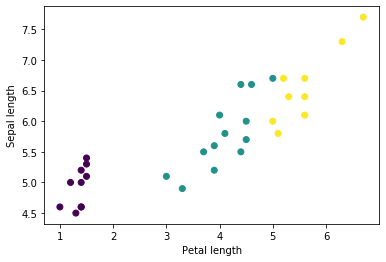

In [11]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

要简化模型构建步骤，请创建一个函数以将特征字典重新打包为形状为 `(batch_size, num_features)` 的单个数组。

此函数使用 [tf.stack](https://www.tensorflow.org/api_docs/python/tf/stack) 方法，该方法从张量列表中获取值，并创建指定维度的组合张量:

In [12]:
def pack_features_vector(features, labels):
  """将特征打包到一个数组中"""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

然后使用 [tf.data.Dataset.map](https://www.tensorflow.org/api_docs/python/tf/data/dataset/map) 方法将每个 `(features,label)` 对中的 `features` 打包到训练数据集中：

In [13]:
train_dataset = train_dataset.map(pack_features_vector)

 `Dataset` 的特征元素被构成了形如 `(batch_size, num_features)` 的数组。我们来看看前几个样本:

In [14]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[5.1 2.5 3.  1.1]
 [6.5 3.  5.8 2.2]
 [4.8 3.4 1.6 0.2]
 [5.4 3.9 1.7 0.4]
 [4.9 3.1 1.5 0.1]], shape=(5, 4), dtype=float32)


## 选择模型类型

### 为何要使用模型?

[模型](https://developers.google.com/machine-learning/crash-course/glossary#model)是指特征与标签之间的关系。对于鸢尾花分类问题，模型定义了花萼和花瓣测量值与预测的鸢尾花品种之间的关系。一些简单的模型可以用几行代数进行描述，但复杂的机器学习模型拥有大量难以汇总的参数。


您能否在不使用机器学习的情况下确定四个特征与鸢尾花品种之间的关系？也就是说，您能否使用传统编程技巧（例如大量条件语句）创建模型？也许能，前提是反复分析该数据集，并最终确定花瓣和花萼测量值与特定品种的关系。对于更复杂的数据集来说，这会变得非常困难，或许根本就做不到。一个好的机器学习方法可为您确定模型。如果您将足够多的代表性样本馈送到正确类型的机器学习模型中，该程序便会为您找出相应的关系。

### 选择模型

我们需要选择要进行训练的模型类型。模型具有许多类型，挑选合适的类型需要一定的经验。本教程使用神经网络来解决鸢尾花分类问题。[神经网络](https://developers.google.com/machine-learning/glossary/#neural_network)可以发现特征与标签之间的复杂关系。神经网络是一个高度结构化的图，其中包含一个或多个[隐含层](https://developers.google.com/machine-learning/glossary/#hidden_layer)。每个隐含层都包含一个或多个[神经元](https://developers.google.com/machine-learning/glossary/#neuron)。 神经网络有多种类别，该程序使用的是密集型神经网络，也称为[全连接神经网络](https://developers.google.com/machine-learning/glossary/#fully_connected_layer) : 一个层中的神经元将从上一层中的每个神经元获取输入连接。例如，图 2 显示了一个密集型神经网络，其中包含 1 个输入层、2 个隐藏层以及 1 个输出层：

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/custom_estimators/full_network.png"
         alt="网络结构示意图: 输入层, 2 隐含层, 输出层">
  </td></tr>
  <tr><td align="center">
    <b>图 2.</b> 包含特征、隐藏层和预测的神经网络<br/>&nbsp;
  </td></tr>
</table>

当图 2 中的模型经过训练并获得无标签样本后，它会产生 3 个预测结果：相应鸢尾花属于指定品种的可能性。这种预测称为[推理](https://developers.google.com/machine-learning/crash-course/glossary#inference)。对于该示例，输出预测结果的总和是 1.0。在图 2 中，该预测结果分解如下：山鸢尾为 0.02，变色鸢尾为 0.95，维吉尼亚鸢尾为 0.03。这意味着该模型预测某个无标签鸢尾花样本是变色鸢尾的概率为 95％。

### 使用 Keras 创建模型

TensorFlow [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras) API 是创建模型和层的首选方式。通过该 API，您可以轻松地构建模型并进行实验，而将所有部分连接在一起的复杂工作则由 Keras 处理。

[tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) 模型是层的线性堆叠。该模型的构造函数会采用一系列层实例；在本示例中，采用的是 2 个[密集层](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)（各自包含10个节点）,以及 1 个输出层（包含 3 个代表标签预测的节点。第一个层的 `input_shape` 参数对应该数据集中的特征数量，它是一项必需参数：

In [15]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # 需要给出输入的形式
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

[激活函数](https://developers.google.com/machine-learning/crash-course/glossary#activation_function)可决定层中每个节点的输出形式。 这些非线性关系很重要，如果没有它们，模型将等同于单个层。[激活函数](https://www.tensorflow.org/api_docs/python/tf/keras/activations)有很多种，但隐藏层通常使用 [ReLU](https://developers.google.com/machine-learning/crash-course/glossary#ReLU)。

隐藏层和神经元的理想数量取决于问题和数据集。与机器学习的多个方面一样，选择最佳的神经网络形状需要一定的知识水平和实验基础。一般来说，增加隐藏层和神经元的数量通常会产生更强大的模型，而这需要更多数据才能有效地进行训练。

### 使用模型

我们快速了解一下此模型如何处理一批特征：


In [16]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=231, shape=(5, 3), dtype=float32, numpy=
array([[-0.40338838,  0.01194552, -1.964499  ],
       [-0.5877474 ,  0.02103703, -2.9969394 ],
       [-0.40222907,  0.35343137, -0.7817157 ],
       [-0.4376807 ,  0.40464264, -0.8379218 ],
       [-0.39644662,  0.31841943, -0.8436158 ]], dtype=float32)>

在此示例中，每个样本针对每个类别返回一个 [logit](https://developers.google.com/machine-learning/crash-course/glossary#logits)。

要将这些对数转换为每个类别的概率，请使用 [softmax](https://developers.google.com/machine-learning/crash-course/glossary#softmax) 函数:

In [17]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=236, shape=(5, 3), dtype=float32, numpy=
array([[0.36700222, 0.55596304, 0.07703481],
       [0.3415203 , 0.62778115, 0.03069854],
       [0.2622449 , 0.55832386, 0.17943124],
       [0.25050646, 0.58161455, 0.167879  ],
       [0.27149206, 0.5549062 , 0.17360175]], dtype=float32)>

对每个类别执行 `tf.argmax` 运算可得出预测的类别索引。不过，该模型尚未接受训练，因此这些预测并不理想。

In [18]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
    Labels: [1 2 0 0 0 2 0 1 0 2 0 0 2 2 2 2 1 2 2 1 2 0 2 1 0 2 2 1 1 1 2 2]


## 训练模型

[训练](https://developers.google.com/machine-learning/crash-course/glossary#training)  是一个机器学习阶段，在此阶段中，模型会逐渐得到优化，也就是说，模型会了解数据集。目标是充分了解训练数据集的结构，以便对未见过的数据进行预测。如果您从训练数据集中获得了过多的信息，预测便会仅适用于模型见过的数据，但是无法泛化。此问题被称之为[过拟合](https://developers.google.com/machine-learning/crash-course/glossary#overfitting)—就好比将答案死记硬背下来，而不去理解问题的解决方式。

鸢尾花分类问题是[监督式机器学习](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning)的一个示例: 模型通过包含标签的样本加以训练。 而在[非监督式机器学习](https://developers.google.com/machine-learning/glossary/#unsupervised_machine_learning)中，样本不包含标签。相反，模型通常会在特征中发现一些规律。

### 定义损失和梯度函数

在训练和评估阶段，我们都需要计算模型的[损失](https://developers.google.com/machine-learning/crash-course/glossary#loss)。 这样可以衡量模型的预测结果与预期标签有多大偏差，也就是说，模型的效果有多差。我们希望尽可能减小或优化这个值。

我们的模型会使用 `tf.keras.losses.SparseCategoricalCrossentropy` 函数计算其损失，此函数会接受模型的类别概率预测结果和预期标签，然后返回样本的平均损失。

In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [20]:
def loss(model, x, y):
  y_ = model(x)

  return loss_object(y_true=y, y_pred=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 2.1644210815429688


使用 [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) 的前后关系来计算[梯度](https://developers.google.com/machine-learning/crash-course/glossary#gradient)以优化你的模型:

In [21]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

### 创建优化器

[优化器](https://developers.google.com/machine-learning/crash-course/glossary#optimizer) 会将计算出的梯度应用于模型的变量，以使 `loss` 函数最小化。您可以将损失函数想象为一个曲面（见图 3），我们希望通过到处走动找到该曲面的最低点。梯度指向最高速上升的方向，因此我们将沿相反的方向向下移动。我们以迭代方式计算每个批次的损失和梯度，以在训练过程中调整模型。模型会逐渐找到权重和偏差的最佳组合，从而将损失降至最低。损失越低，模型的预测效果就越好。

<table>
  <tr><td>
    <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%"
         alt="Optimization algorithms visualized over time in 3D space.">
  </td></tr>
  <tr><td align="center">
    <b>图 3.</b> 优化算法在三维空间中随时间推移而变化的可视化效果。<br/>(来源: <a href="http://cs231n.github.io/neural-networks-3/">斯坦福大学 CS231n 课程</a>，MIT 许可证，Image credit: <a href="https://twitter.com/alecrad">Alec Radford</a>)
  </td></tr>
</table>

TensorFlow有许多可用于训练的[优化算法](https://www.tensorflow.org/api_guides/python/train)。此模型使用的是 [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer) ， 它可以实现[随机梯度下降法](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent)（SGD）。`learning_rate` 被用于设置每次迭代（向下行走）的步长。 这是一个 *超参数* ，您通常需要调整此参数以获得更好的结果。

我们来设置优化器：

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

我们将使用它来计算单个优化步骤：

In [23]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 2.1644210815429688
Step: 1,         Loss: 1.8952136039733887


### 训练循环


一切准备就绪后，就可以开始训练模型了！训练循环会将数据集样本馈送到模型中，以帮助模型做出更好的预测。以下代码块可设置这些训练步骤：

1. 迭代每个周期。通过一次数据集即为一个周期。
2. 在一个周期中，遍历训练 `Dataset` 中的每个样本，并获取样本的*特征*（`x`）和*标签*（`y`）。
3. 根据样本的特征进行预测，并比较预测结果和标签。衡量预测结果的不准确性，并使用所得的值计算模型的损失和梯度。
4. 使用 `optimizer` 更新模型的变量。
5. 跟踪一些统计信息以进行可视化。
6. 对每个周期重复执行以上步骤。


`num_epochs` 变量是遍历数据集集合的次数。与直觉恰恰相反的是，训练模型的时间越长，并不能保证模型就越好。`num_epochs` 是一个可以调整的[超参数](https://developers.google.com/machine-learning/glossary/#hyperparameter)。选择正确的次数通常需要一定的经验和实验基础。

In [24]:
## Note: 使用相同的模型变量重新运行此单元

# 保留结果用于绘制
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # 优化模型
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # 追踪进度
    epoch_loss_avg(loss_value)  # 添加当前的 batch loss
    # 比较预测标签与真实标签
    epoch_accuracy(y, model(x))

  # 循环结束
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.435, Accuracy: 30.000%
Epoch 050: Loss: 0.091, Accuracy: 97.500%
Epoch 100: Loss: 0.062, Accuracy: 97.500%
Epoch 150: Loss: 0.052, Accuracy: 98.333%
Epoch 200: Loss: 0.055, Accuracy: 99.167%


### 可视化损失函数随时间推移而变化的情况

虽然输出模型的训练过程有帮助，但查看这一过程往往*更有帮助*。 [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) 是与 TensorFlow 封装在一起的出色可视化工具，不过我们可以使用 `matplotlib` 模块创建基本图表。

解读这些图表需要一定的经验，不过您确实希望看到*损失*下降且*准确率*上升。

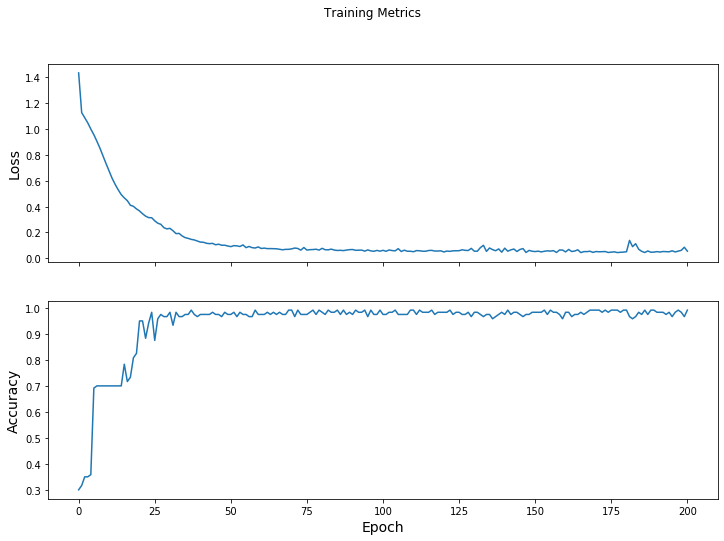

In [25]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## 评估模型的效果

模型已经过训练，现在我们可以获取一些关于其效果的统计信息了。

*评估* 指的是确定模型做出预测的效果。要确定模型在鸢尾花分类方面的效果，请将一些花萼和花瓣测量值传递给模型，并要求模型预测它们所代表的鸢尾花品种。然后，将模型的预测结果与实际标签进行比较。例如，如果模型对一半输入样本的品种预测正确，则 [准确率](https://developers.google.com/machine-learning/glossary/#accuracy) 为 `0.5` 。 图 4 显示的是一个效果更好一些的模型，该模型做出 5 次预测，其中有 4 次正确，准确率为 80%：

<table cellpadding="8" border="0">
  <colgroup>
    <col span="4" >
    <col span="1" bgcolor="lightblue">
    <col span="1" bgcolor="lightgreen">
  </colgroup>
  <tr bgcolor="lightgray">
    <th colspan="4">样本特征</th>
    <th colspan="1">标签</th>
    <th colspan="1" >模型预测</th>
  </tr>
  <tr>
    <td>5.9</td><td>3.0</td><td>4.3</td><td>1.5</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr>
    <td>6.9</td><td>3.1</td><td>5.4</td><td>2.1</td><td align="center">2</td><td align="center">2</td>
  </tr>
  <tr>
    <td>5.1</td><td>3.3</td><td>1.7</td><td>0.5</td><td align="center">0</td><td align="center">0</td>
  </tr>
  <tr>
    <td>6.0</td> <td>3.4</td> <td>4.5</td> <td>1.6</td> <td align="center">1</td><td align="center" bgcolor="red">2</td>
  </tr>
  <tr>
    <td>5.5</td><td>2.5</td><td>4.0</td><td>1.3</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr><td align="center" colspan="6">
    <b>图 4.</b> 准确率为 80% 的鸢尾花分类器<br/>&nbsp;
  </td></tr>
</table>

### 建立测试数据集

评估模型与训练模型相似。最大的区别在于，样本来自一个单独的[测试集](https://developers.google.com/machine-learning/crash-course/glossary#test_set)，而不是训练集。为了公正地评估模型的效果，用于评估模型的样本务必与用于训练模型的样本不同。

测试 `Dataset` 的建立与训练 `Dataset` 相似。下载 CSV 文本文件并解析相应的值，然后对数据稍加随机化处理：

In [26]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [27]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

### 根据测试数据集评估模型

与训练阶段不同，模型仅评估测试数据的一个[周期](https://developers.google.com/machine-learning/glossary/#epoch)。在以下代码单元格中，我们会遍历测试集中的每个样本，然后将模型的预测结果与实际标签进行比较。这是为了衡量模型在整个测试集中的准确率。

In [28]:
test_accuracy = tf.keras.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


例如，我们可以看到对于最后一批数据，该模型通常预测正确：

In [29]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: id=115075, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 1],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

## 使用经过训练的模型进行预测

我们已经训练了一个模型并“证明”它是有效的，但在对鸢尾花品种进行分类方面，这还不够。现在，我们使用经过训练的模型对 [无标签样本](https://developers.google.com/machine-learning/glossary/#unlabeled_example)（即包含特征但不包含标签的样本）进行一些预测。

在现实生活中，无标签样本可能来自很多不同的来源，包括应用、CSV 文件和数据 Feed。暂时我们将手动提供三个无标签样本以预测其标签。回想一下，标签编号会映射到一个指定的表示法：

* `0`: 山鸢尾
* `1`: 变色鸢尾
* `2`: 维吉尼亚鸢尾

In [30]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (99.9%)
Example 1 prediction: Iris versicolor (100.0%)
Example 2 prediction: Iris virginica (96.2%)
